### 작업개요
* 완성된 시각화 코드에서, 토크나이저와 사전 학습 모델을 변경하여 시각화 한다
* 파인튜닝 이후 시각화 결과의 변화를 관찰한다

In [1]:
# att.detach().numpy()
# # matplotlib에서 한글 표시
# # https://teddylee777.github.io/colab/colab-korean
# https://teddylee777.github.io/visualization/matplotlib-시각화-한글폰트적용
# !apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# # 설치한 뒤에 런타임 재시작이 필수

### Import

In [2]:
import os
import time
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

import torch
import wandb
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

/home/hdh/PycharmProjects/huggingface_bert/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

#### for finetune

In [3]:
# Load the dataset into a pandas dataframe.
df_train = pd.read_csv("data/h04w4/train_H04W4_220511.txt", delimiter='\t', dtype=str, header=0, names=['text', 'label'])
df_test = pd.read_csv("data/h04w4/test_H04W4_220511.txt", delimiter='\t', dtype=str, header=0, names=['text', 'label'])
# Get the lists of sentences and their labels.
sentences = df_train.text.values
labels = df_train.label.values.astype('int64')

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df_train.shape[0]))

# Display 10 random rows from the data.
# df_train.head(10)

Number of training sentences: 2,095



### Load Tokenizer

#### Load bert-base-multilingual-cased

In [132]:
tokenizer = BertTokenizer.from_pretrained(
        'bert-base-multilingual-cased', clean_text=False, do_lower_case=True, strip_accents=False, handle_chinese_chars=True)
tok = tokenizer.tokenize('제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계')
print(len(tok), tok)

23 ['제', '##1', '채', '##널', '구간', '##동안', '주', '##변', '차', '##량', '노', '##드', '##로부터', '비', '##컨', '메', '##시', '##지를', '수', '##신', '##하는', '단', '##계']


#### Load pre-trained

In [34]:
tokenizer = BertTokenizer.from_pretrained(
        'h04w4_trained_model', clean_text=False, do_lower_case=True, strip_accents=False, handle_chinese_chars=True)
tok = tokenizer.tokenize('제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계')
print(len(tok), tok)

11 ['제1', '채널', '구간', '##동안', '주변', '차량', '노드로부터', '비컨', '메시지를', '수신하는', '단계']


In [35]:
import wandb
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {

        'learning_rate': {
            'values': [ 5e-5, 3e-5, 2e-5]
        },
        'batch_size': {
            'values': [16, 32]
        },
        'epochs':{
            'values':[2, 3, 4]
        }
    }
}
sweep_defaults = {
    'learning_rate': 5e-5,
    'batch_size': 32,
    'epochs': 15
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: s53et4d6
Sweep URL: https://wandb.ai/sejongict/uncategorized/sweeps/s53et4d6


In [36]:
# aa0b8b5dcab973004277f569aea32d30c4fc1655

In [37]:
max_length = 128

In [38]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


/home/hdh/PycharmProjects/huggingface_bert/venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2263: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [39]:
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

/tmp/ipykernel_1911/3716748345.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [40]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,885 training samples
  210 validation samples


In [41]:
# WANDB PARAMETER
def ret_dataloader():
    batch_size = wandb.config.batch_size
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

### Load Pre-trained BERT model

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [43]:
def ret_model():

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-multilingual-cased", 
        # cached_path='./',
        num_labels = 5, 
        output_attentions = True, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )
    return model

In [44]:
def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = AdamW(model.parameters(),
                      lr = wandb.config.learning_rate, 
                      eps = 1e-8 
                    )
    return optimizer

In [45]:
def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    print('epochs =>', epochs)
    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

In [46]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [47]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
PATH = "h04w4_trained_model"
# PATH = "h04w4_trained_model/bert-base-multilingual-cased.pt"

# Set the seed value all over the place to make this reproducible.
def train():
    wandb.init(config=sweep_defaults)
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
    train_dataloader,validation_dataloader = ret_dataloader()
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader,optimizer)

    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42
   
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs
    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
            loss, logits = outputs['loss'], outputs['logits']
            wandb.log({'train_batch_loss':loss.item()})
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        wandb.log({'avg_train_loss':avg_train_loss})

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = model(b_input_ids, 
                                      token_type_ids=None, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)
                loss, logits = outputs['loss'], outputs['logits']
#                 print(outputs)
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy':avg_val_accuracy,'avg_val_loss':avg_val_loss})
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    torch.save(model.state_dict(), os.path.join(PATH, 'bert-base-multilingual-cased.pt'))


In [48]:
wandb.init(config=sweep_defaults)
train_dataloader,validation_dataloader = ret_dataloader()
validation_dataloader

batch_size =  32


### Extract Attentions from bert-base-multilingual-cased

In [133]:
model = ret_model()
model.to(device)

sample = '제1 채널 구간동안 주변 차량 노드로부터 비컨 메시지를 수신하는 단계'
# sample = 'UV 광원을 사용한 보안 인쇄물의 위변조 확인 방법에 있어서,피인쇄물을 준비하는 단계;UV 광원을 상기 제1영역 및 제2영역에 조사하여, 상기 제1영역은 제1색으로 발광하고, 제2영역은 제2색으로 발광하는 다색 발광 단계;UV 광원의 조사를 중지하는 단계; 및UV 조사가 중지된 이후, 상기 제1영역의 발광은 사라지고, 동시에 제2영역은 소정 시간 동안 제3색을 발광하고, 이후 제3색이 사라지거나, 제4색으로 일정 시간 동안 발광하는 색변환 단계;를 포함하고, 상기 피인쇄물은, 형광체을 포함하는 제1 보안 잉크를 사용하여 상기 피인쇄물의 표면에 제1영역이 인쇄되고, 형광체와 인광체을 포함하는 제2 보안 잉크를 사용하여 상기 피인쇄물의 표면에 제2영역이 인쇄된 것인, UV 광원을 사용한 보안 인쇄물의 위변조 확인 방법.'
encoded_sample = tokenizer.encode_plus(
    sample,                      # Sentence to encode.
    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
    max_length = max_length,           # Pad & truncate all sentences.
    pad_to_max_length = False,
    truncation = True,
    return_attention_mask = True,   # Construct attn. masks.
    return_tensors = 'pt',     # Return pytorch tensors.
    )
sample_ids = encoded_sample['input_ids']
sample_masks = encoded_sample['attention_mask']

b_input_ids = torch.cat([sample_ids]).to(device)
b_input_mask = torch.cat([sample_masks]).to(device)
# b_labels = torch.cat(sample_tok[2]).to(device)

b_input_ids, len(b_input_ids[0]), b_input_mask, len(b_input_mask[0])
# tokenizer.vocab
sampleid = sample_ids[0].detach().numpy()
# tok = tokenizer.tokenize(sample)
tok = tokenizer.convert_ids_to_tokens(sampleid)

model.zero_grad()
outputs = model(b_input_ids, 
                token_type_ids=None, 
                attention_mask=b_input_mask,)
# print(outputs['attentions'])  # loss, logits, hidden_states=None, attentions 순으로 출력
attentions = torch.cat(outputs['attentions']).to('cpu')
#     attentions.shape  # layer, batch_size (squeezed by torch.cat), num_heads, sequence_length, sequence_length)
attentions = attentions.permute(2,1,0,3)
layers = len(attentions[0][0])
heads = len(attentions[0])
seqlen = len(attentions)
#     layers,heads,seqlen


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

### Visualization Attention

In [50]:
# 시각화 과정에서 수치 표시
# https://collocationvoca.tistory.com/13

In [51]:
matplotlib.matplotlib_fname()

'/home/hdh/PycharmProjects/huggingface_bert/venv/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'

In [52]:
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
# plt.rcParams['font.family'] = 'Malgun Gothic'

Attention weights for token 채널


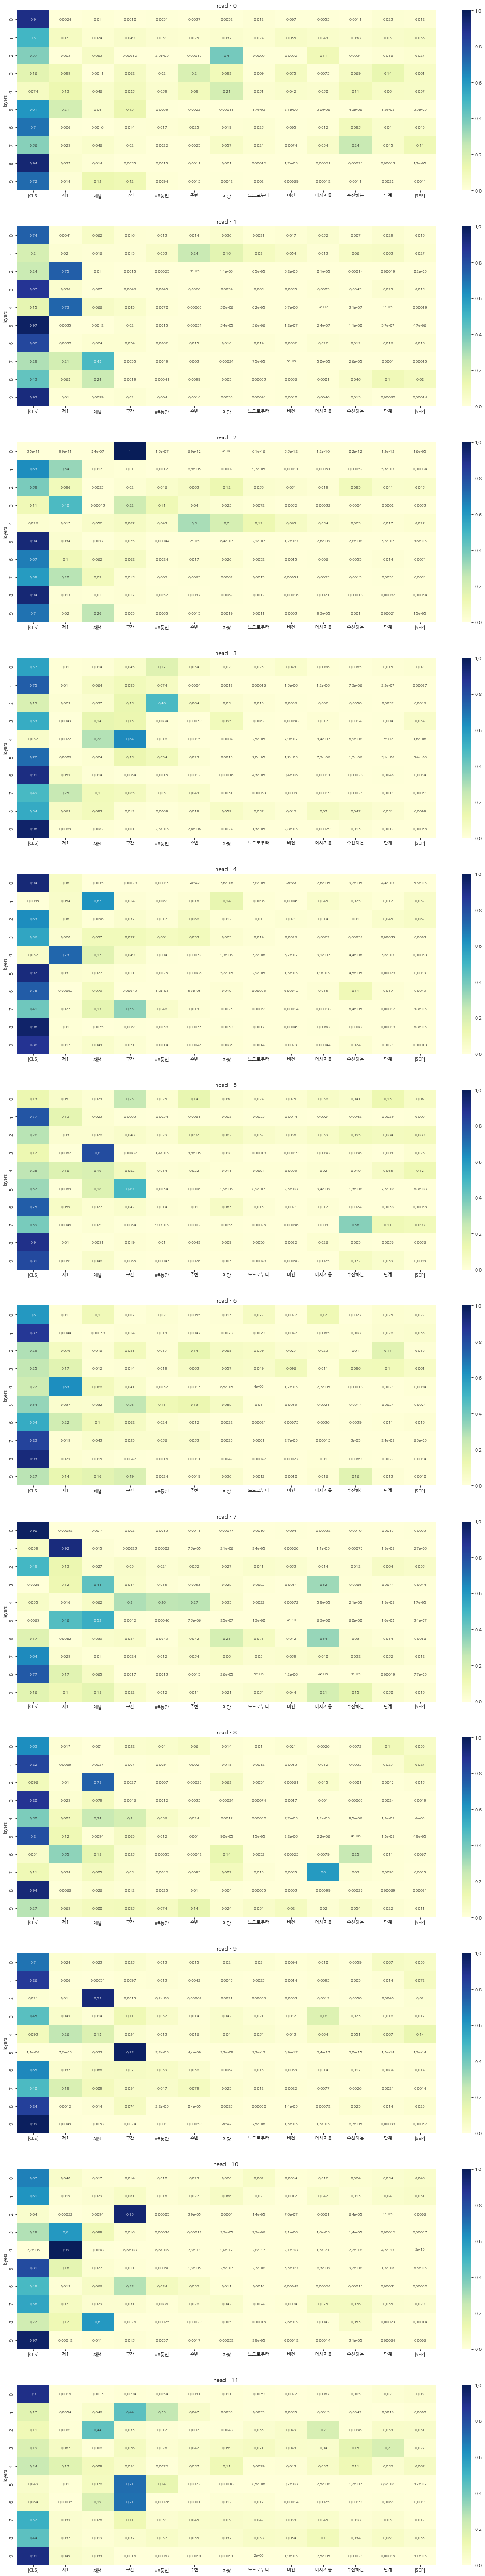

In [73]:
p_pos = 2
attentions_pos = attentions[p_pos]
attentions_pos.shape

cols = 1
# rows = int(heads/cols)
rows = int(len(attentions_pos)/cols)

# plt.rcParams["font.family"] = "NanumBarunGothic"
# plt.rc('font', family='NanumBarunGothic') 
# 출처: https://dasom.net/108 [:::: gangserver's blog :::::티스토리]
fig, axes = plt.subplots(rows, cols, figsize = (20,100))
axes = axes.flat
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(attentions_pos):

    #im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att.detach().numpy()[1:-1], vmin = 0, vmax = 1, ax = axes[i],
                xticklabels = tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
    # sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok)
    axes[i].set_title(f'head - {i} ' )
    axes[i].set_ylabel('layers')
plt.savefig(f'result_image/{tok[p_pos]}.png')

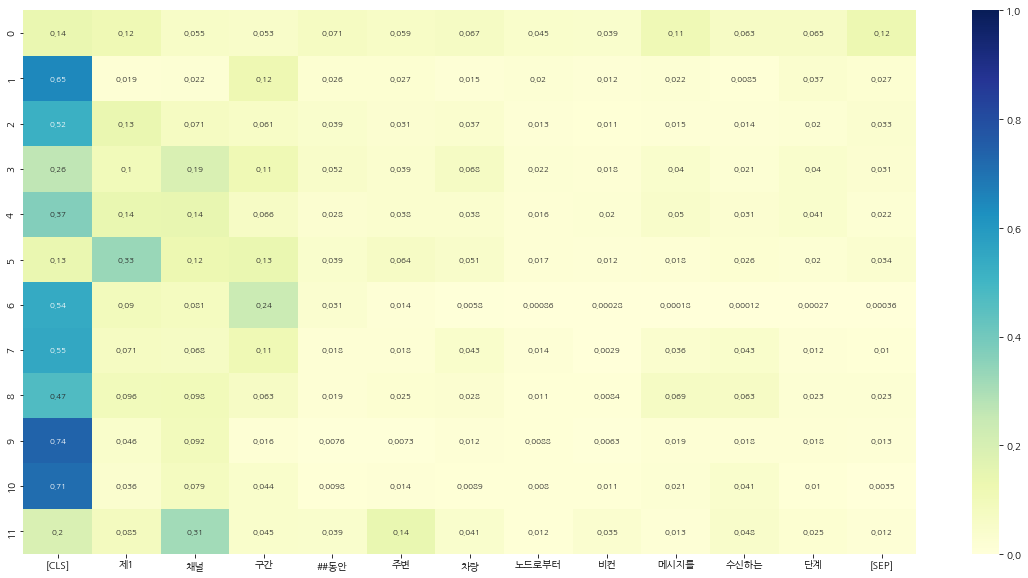

In [54]:
# See average attention for token
avg_attention = attentions_pos.mean(dim = 0)
fig, axes = plt.subplots(1, cols, figsize = (20,10))
sns.heatmap(avg_attention.detach().numpy(), 
            vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
plt.savefig(f'result_image/{tok[p_pos]}_1.png')

### 2022.10.10 진행상황
* attention heatmap 시각화 완료
* 영어데이터로 변경해서 시각화
* 한글 데이터를 사용하되 토크나이저 문제를 해결 후 시각화
    * bert-base-multilingual-cased를 사용함으로써 한글 깨짐 해결 
* 앞으로 할 일
    3. 토큰 스코어 시각화
        * 토큰스코어: https://github.com/mcelikkaya/medium_articles2/blob/main/bert_qa_tune.ipynb
        * pretrain: https://cryptosalamander.tistory.com/139

#### 참고
* https://colab.research.google.com/github/PyTorchKorea/tutorials-kr/blob/master/docs/_downloads/67710f3d40ca3863323ce02dddbf8618/save_load_across_devices.ipynb#scrollTo=FySKcUVQig5q

In [25]:
# 저장하기
# torch.save(model.state_dict(), PATH)

# 불러오기
# device = torch.device("cuda")
# model = Net()
# model.load_state_dict(torch.load(PATH))
# model.to(device)

In [26]:
from IPython import display

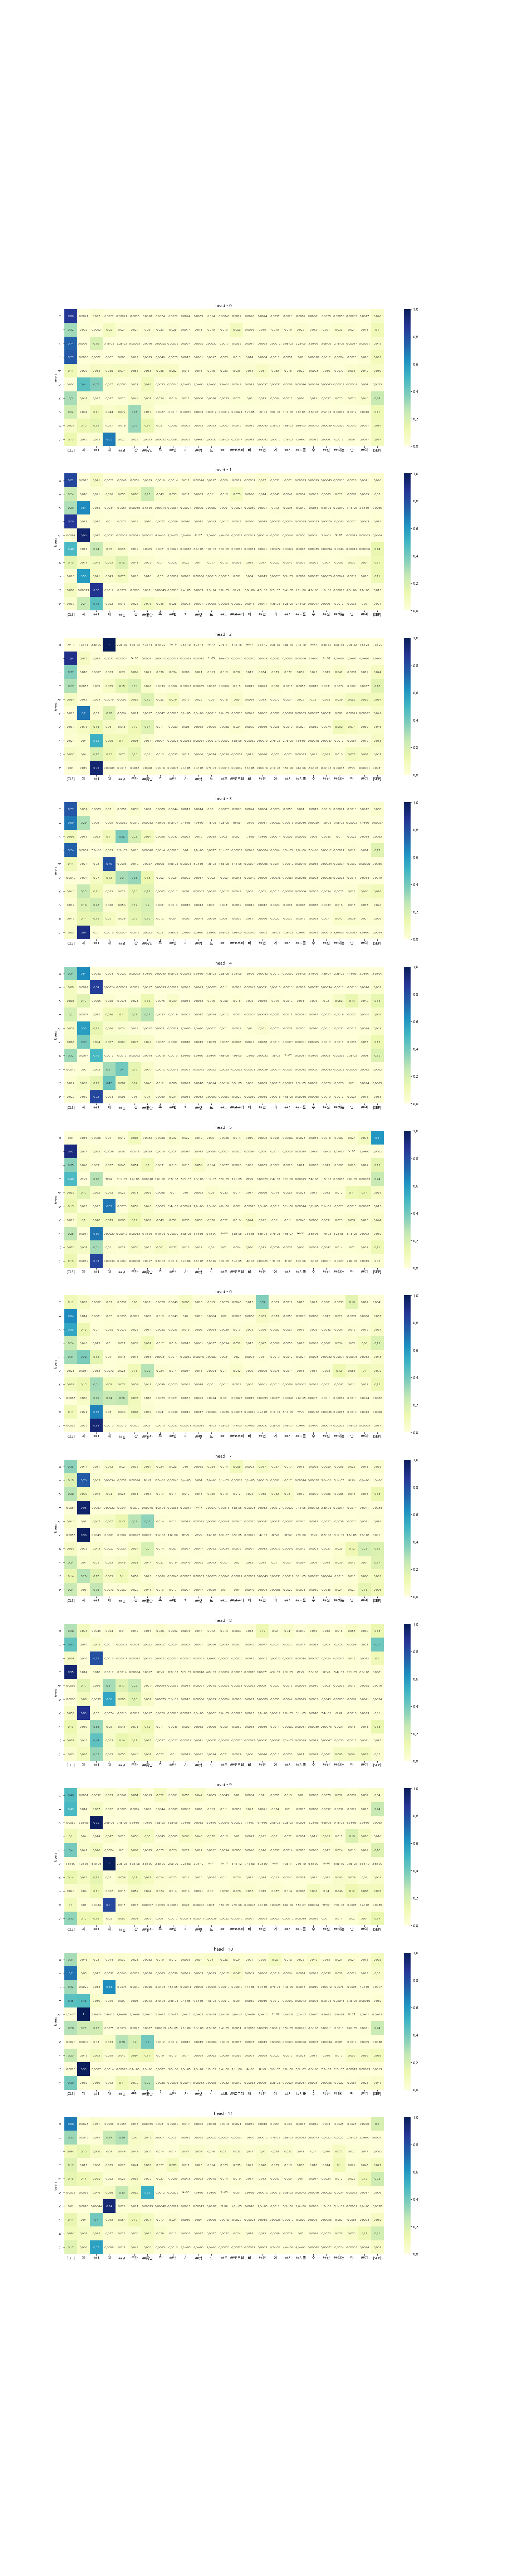

In [27]:
display.Image(f'result_image/{tok[p_pos]}.png')

In [ ]:
display.Image(f'result_image/{tok[p_pos]}_1.png')

### Fine-tuning

In [ ]:
train()

In [ ]:
# wandb.agent(sweep_id, function=train)

In [134]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", 
    # cached_path='./',
    num_labels = 5, 
    output_attentions = True, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
chkpoint = torch.load('h04w4_trained_model/bert-base-multilingual-cased.pt')
model.load_state_dict(chkpoint)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

<All keys matched successfully>

In [135]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [136]:
# model.zero_grad()
finetuned_outputs = model(b_input_ids, 
                 token_type_ids=None, 
                 attention_mask=b_input_mask,)
# print(outputs['attentions'])  # loss, logits, hidden_states=None, attentions 순으로 출력
finetuned_attentions = torch.cat(finetuned_outputs['attentions']).to('cpu')
#     attentions.shape  # layer, batch_size (squeezed by torch.cat), num_heads, sequence_length, sequence_length)
finetuned_attentions = finetuned_attentions.permute(2,1,0,3)
finetuned_layers = len(finetuned_attentions[0][0])
finetuned_heads = len(finetuned_attentions[0])
finetuned_seqlen = len(finetuned_attentions)
#     layers,heads,seqlen

p_pos = 2
finetuned_attentions_pos = finetuned_attentions[p_pos]
finetuned_attentions_pos.shape

torch.Size([12, 12, 25])

Attention weights for token ##1


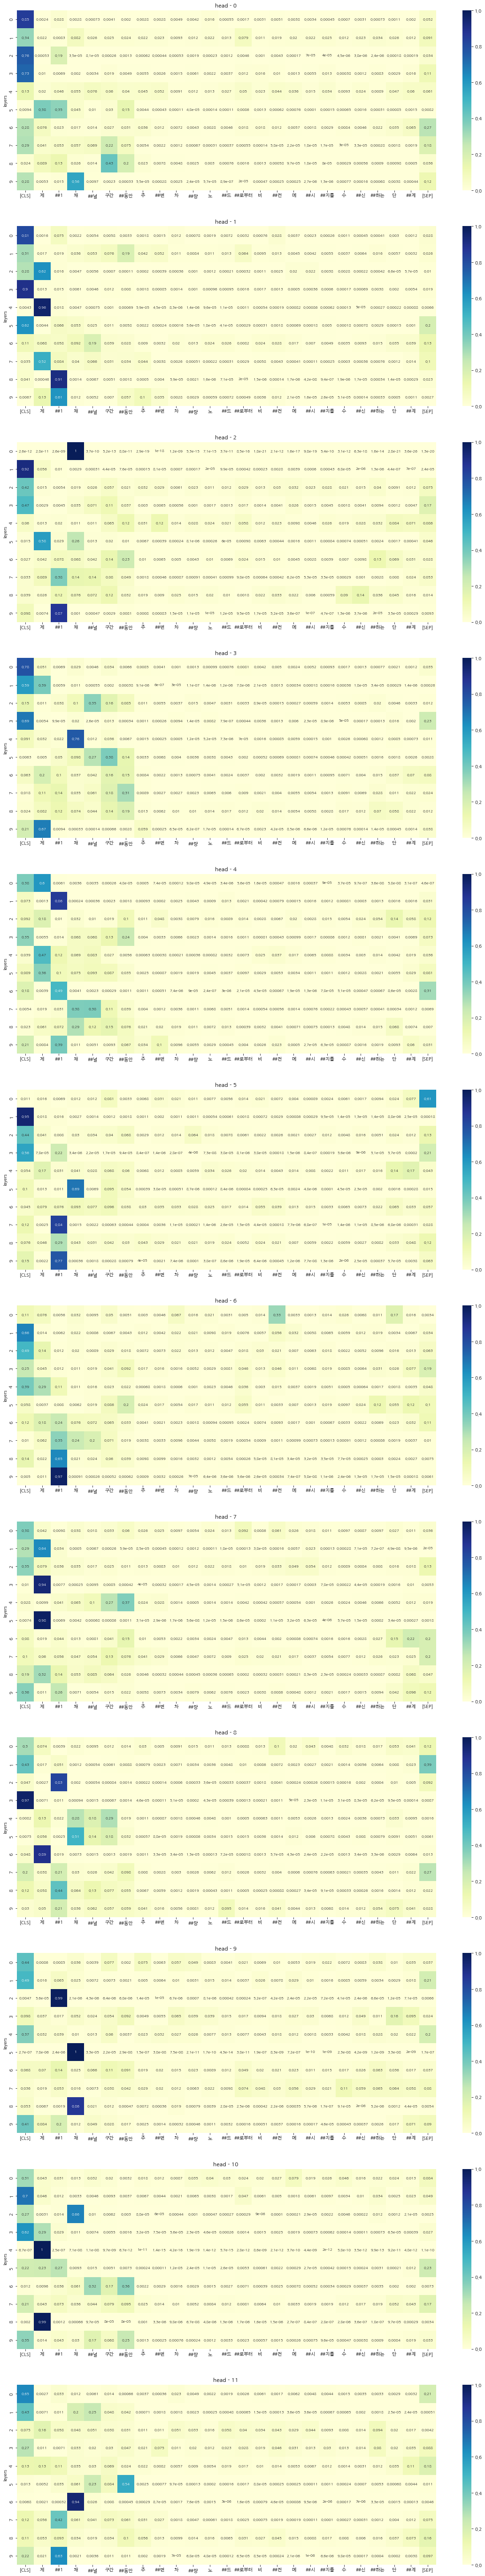

In [31]:
cols = 1
# rows = int(heads/cols)
rows = int(len(finetuned_attentions_pos)/cols)

# plt.rcParams["font.family"] = "NanumBarunGothic"
# plt.rc('font', family='NanumBarunGothic') 
# 출처: https://dasom.net/108 [:::: gangserver's blog :::::티스토리]
fig, axes = plt.subplots(rows, cols, figsize = (20,100))
axes = axes.flat
print (f'Attention weights for token {tok[p_pos]}')
for i,att in enumerate(finetuned_attentions_pos):

    #im = axes[i].imshow(att, cmap='gray')
    sns.heatmap(att.detach().numpy()[1:-1], vmin = 0, vmax = 1, ax = axes[i],
                xticklabels = tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
    # sns.heatmap(att,vmin = 0, vmax = 1,ax = axes[i], xticklabels = tok)
    axes[i].set_title(f'head - {i} ' )
    axes[i].set_ylabel('layers')
plt.savefig(f'result_image/finetuned_{tok[p_pos]}.png')

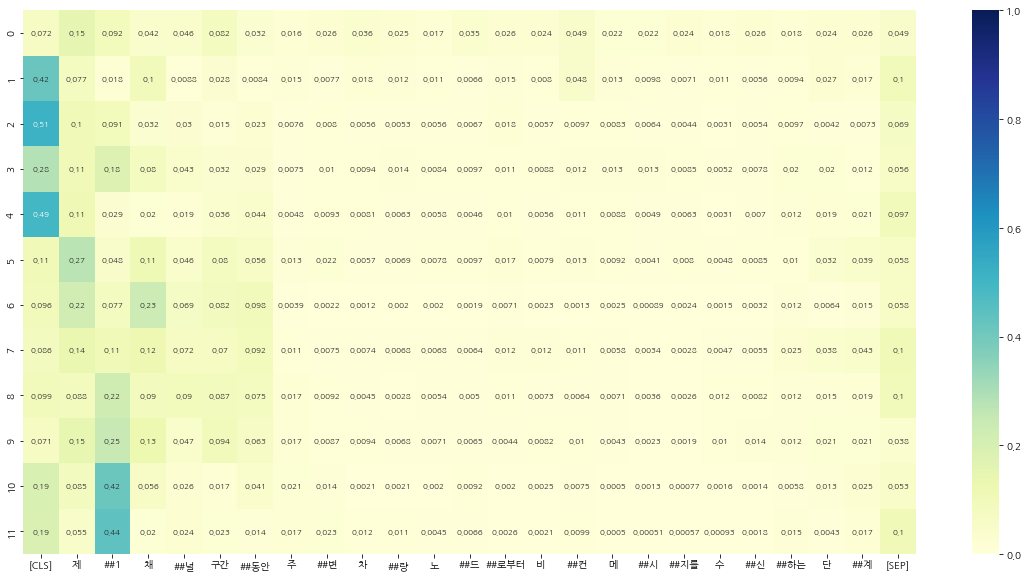

In [32]:
# See average attention for token
finetuned_avg_attention = finetuned_attentions_pos.mean(dim = 0)
fig, axes = plt.subplots(1, cols, figsize = (20,10))
sns.heatmap(finetuned_avg_attention.detach().numpy(), 
            vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')
plt.savefig(f'result_image/finetuned_{tok[p_pos]}_1.png')

Attention weights for token [CLS]
Attention weights for token 제1
Attention weights for token 채널
Attention weights for token 구간
Attention weights for token ##동안
Attention weights for token 주변
Attention weights for token 차량
Attention weights for token 노드로부터
Attention weights for token 비컨
Attention weights for token 메시지를
Attention weights for token 수신하는
Attention weights for token 단계
Attention weights for token [SEP]


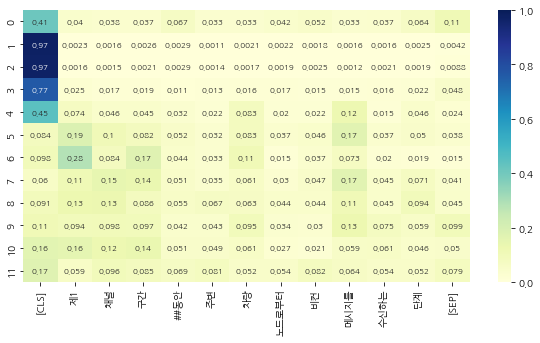

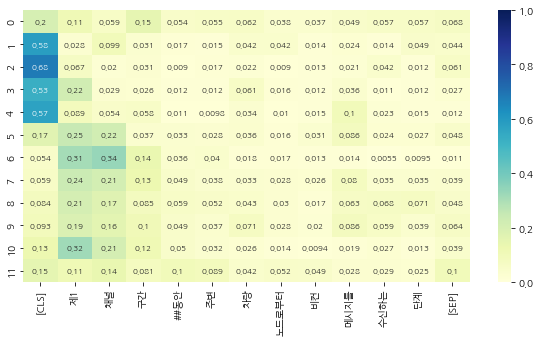

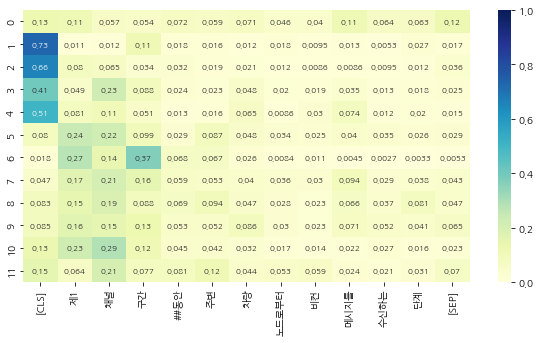

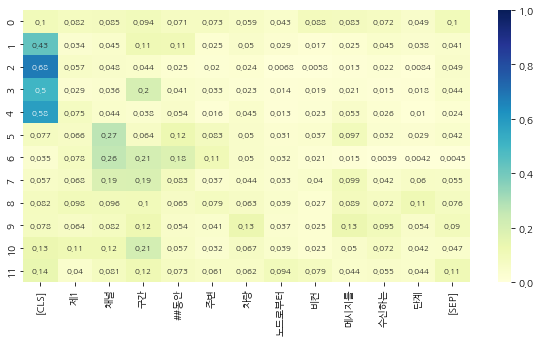

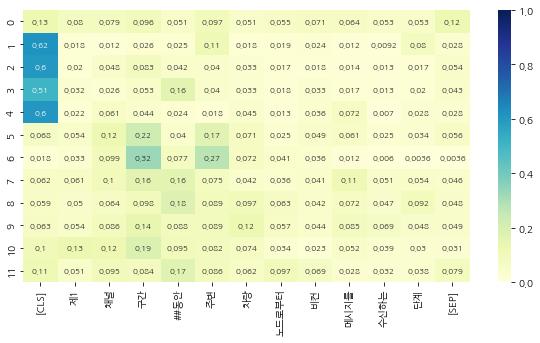

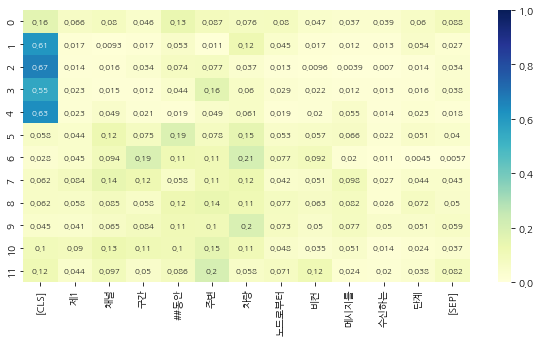

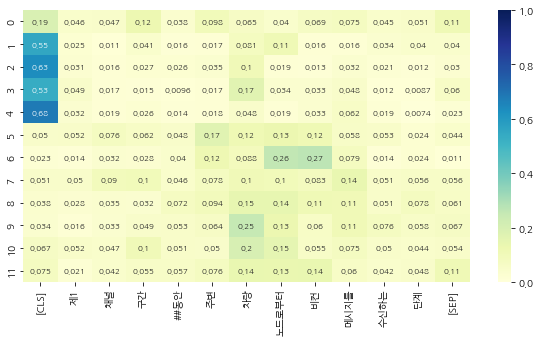

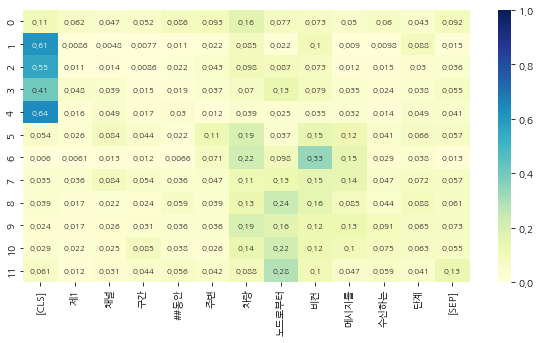

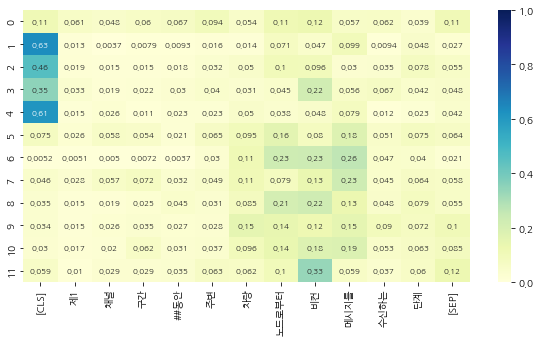

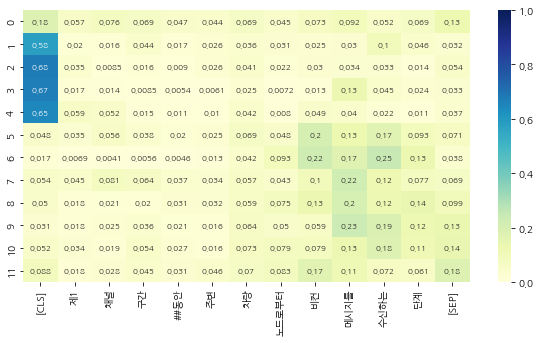

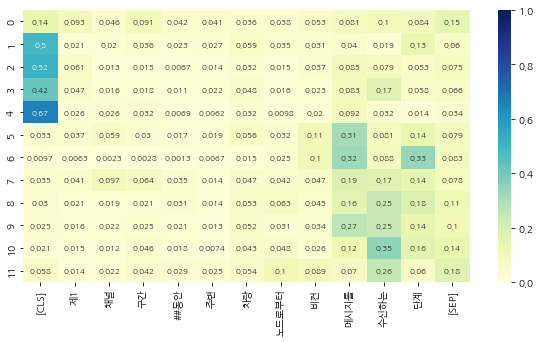

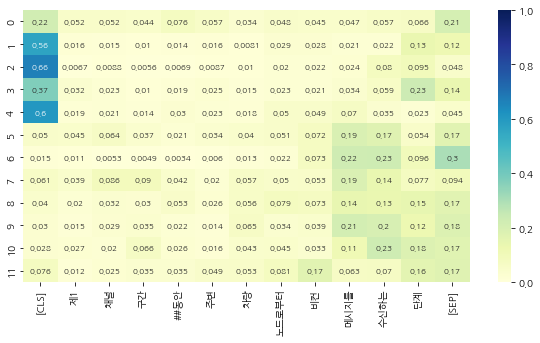

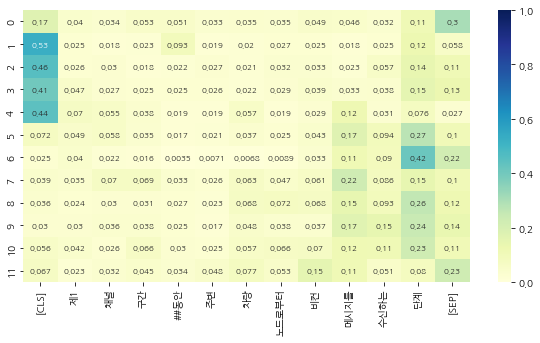

In [67]:
for p_pos in range(finetuned_attentions.shape[0]):
    attentions_pos = finetuned_attentions[p_pos]
    attentions_pos.shape
    cols = 1
    rows = int(len(attentions_pos)/cols)
    print (f'Attention weights for token {tok[p_pos]}')
    avg_attention = attentions_pos.mean(dim = 0)
    fig, axes = plt.subplots(1, cols, figsize = (10,5))
    sns.heatmap(avg_attention.detach().numpy(), 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')

In [33]:
tok[p_pos]

'##1'

In [ ]:
display.Image(f'result_image/{tok[p_pos]}_1.png')

In [ ]:
display.Image(f'result_image/finetuned_{tok[p_pos]}_1.png')

Attention weights for token [CLS]
Attention weights for token 제1
Attention weights for token 채널
Attention weights for token 구간
Attention weights for token ##동안
Attention weights for token 주변
Attention weights for token 차량
Attention weights for token 노드로부터
Attention weights for token 비컨
Attention weights for token 메시지를
Attention weights for token 수신하는
Attention weights for token 단계
Attention weights for token [SEP]


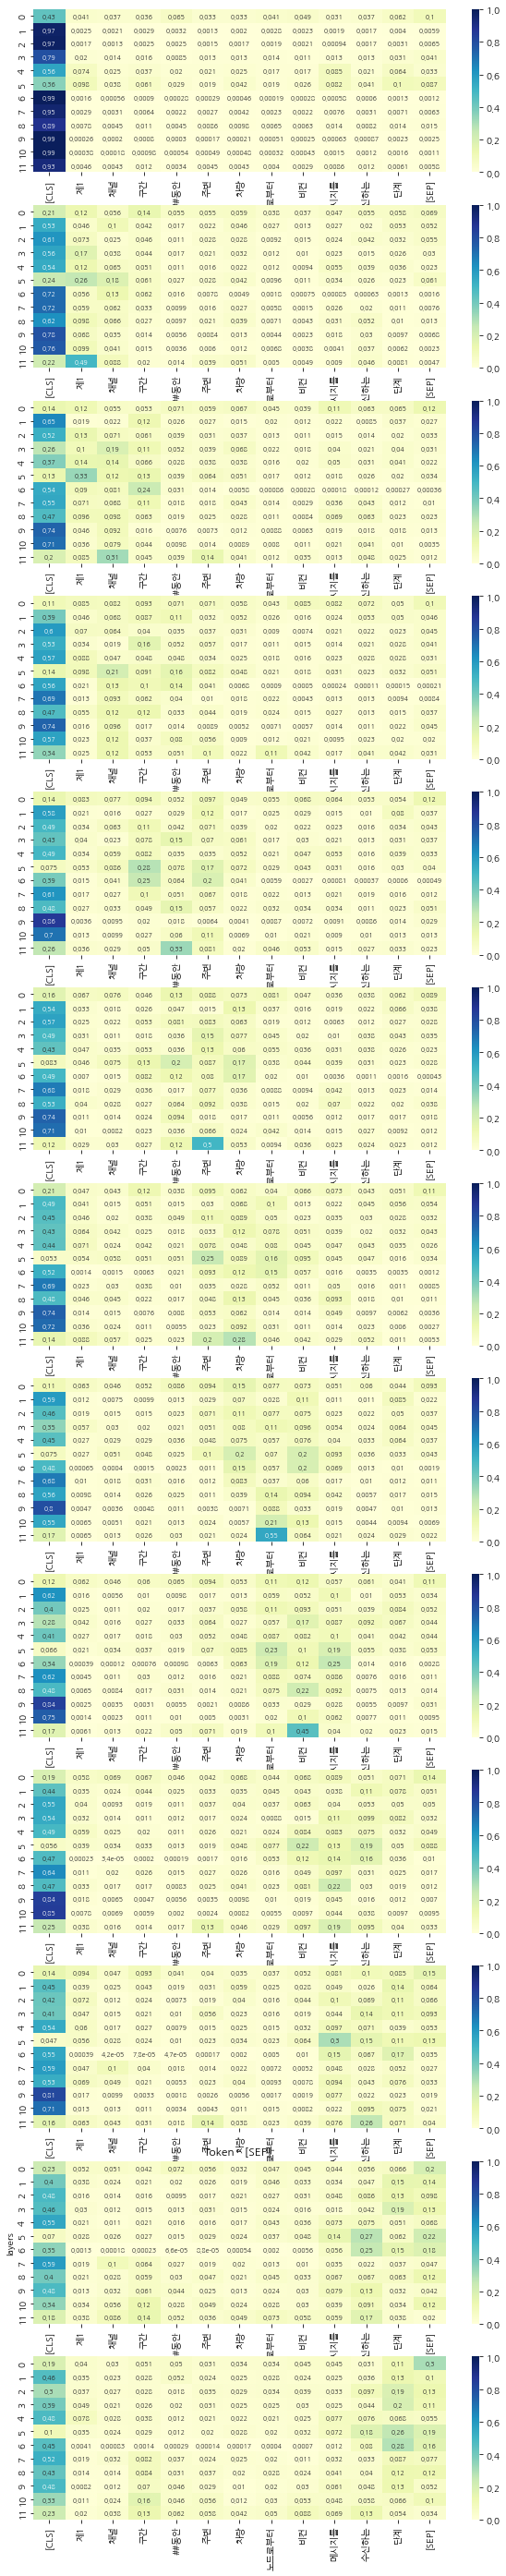

In [78]:
cols = 1
rows = len(attentions_pos)+1

fig, axes = plt.subplots(rows, cols, figsize = (10,50))
axes = axes.flat
for p_pos in range(attentions.shape[0]):
    attentions_pos = attentions[p_pos]
    attentions_pos.shape
    print (f'Attention weights for token {tok[p_pos]}')
    avg_attention = attentions_pos.mean(dim = 0)
#     fig, axes = plt.subplots(1, cols, figsize = (10,5))
    sns.heatmap(avg_attention.detach().numpy(), ax = axes[p_pos], 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':7}, cmap='YlGnBu')
    axes[i].set_title(f'Token - {tok[p_pos]} ' )
    axes[i].set_ylabel('layers')    

Attention weights for token [CLS]
Attention weights for token 제1
Attention weights for token 채널
Attention weights for token 구간
Attention weights for token ##동안
Attention weights for token 주변
Attention weights for token 차량
Attention weights for token 노드로부터
Attention weights for token 비컨
Attention weights for token 메시지를
Attention weights for token 수신하는
Attention weights for token 단계
Attention weights for token [SEP]


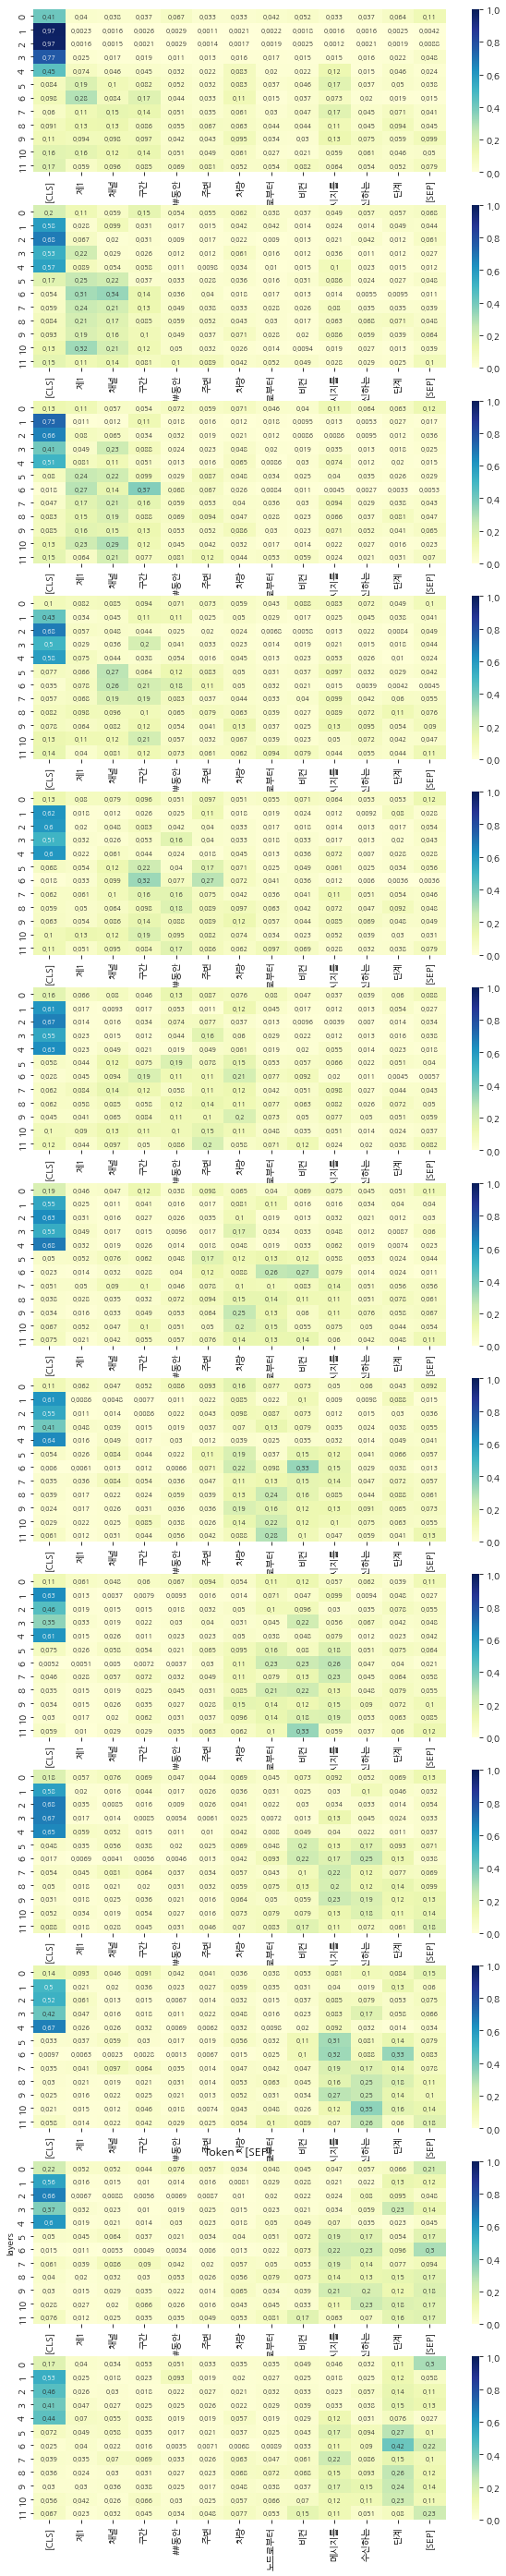

In [79]:
cols = 1
rows = len(attentions_pos)+1

fig, axes = plt.subplots(rows, cols, figsize = (10,50))
axes = axes.flat
for p_pos in range(finetuned_attentions.shape[0]):
    attentions_pos = finetuned_attentions[p_pos]
    attentions_pos.shape
    print (f'Attention weights for token {tok[p_pos]}')
    avg_attention = attentions_pos.mean(dim = 0)
#     fig, axes = plt.subplots(1, cols, figsize = (10,5))
    sns.heatmap(avg_attention.detach().numpy(), ax = axes[p_pos], 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':7}, cmap='YlGnBu')
    axes[i].set_title(f'Token - {tok[p_pos]} ' )
    axes[i].set_ylabel('layers')    
    
# for p_pos in range(finetuned_attentions.shape[0]):
#     attentions_pos = finetuned_attentions[p_pos]
#     attentions_pos.shape
#     cols = 1
#     rows = int(len(attentions_pos)/cols)
#     print (f'Attention weights for token {tok[p_pos]}')
#     avg_attention = attentions_pos.mean(dim = 0)
#     fig, axes = plt.subplots(1, cols, figsize = (10,5))
#     sns.heatmap(avg_attention.detach().numpy(), 
#                 vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':8}, cmap='YlGnBu')

IndexError: index 13 is out of bounds for axis 0 with size 13

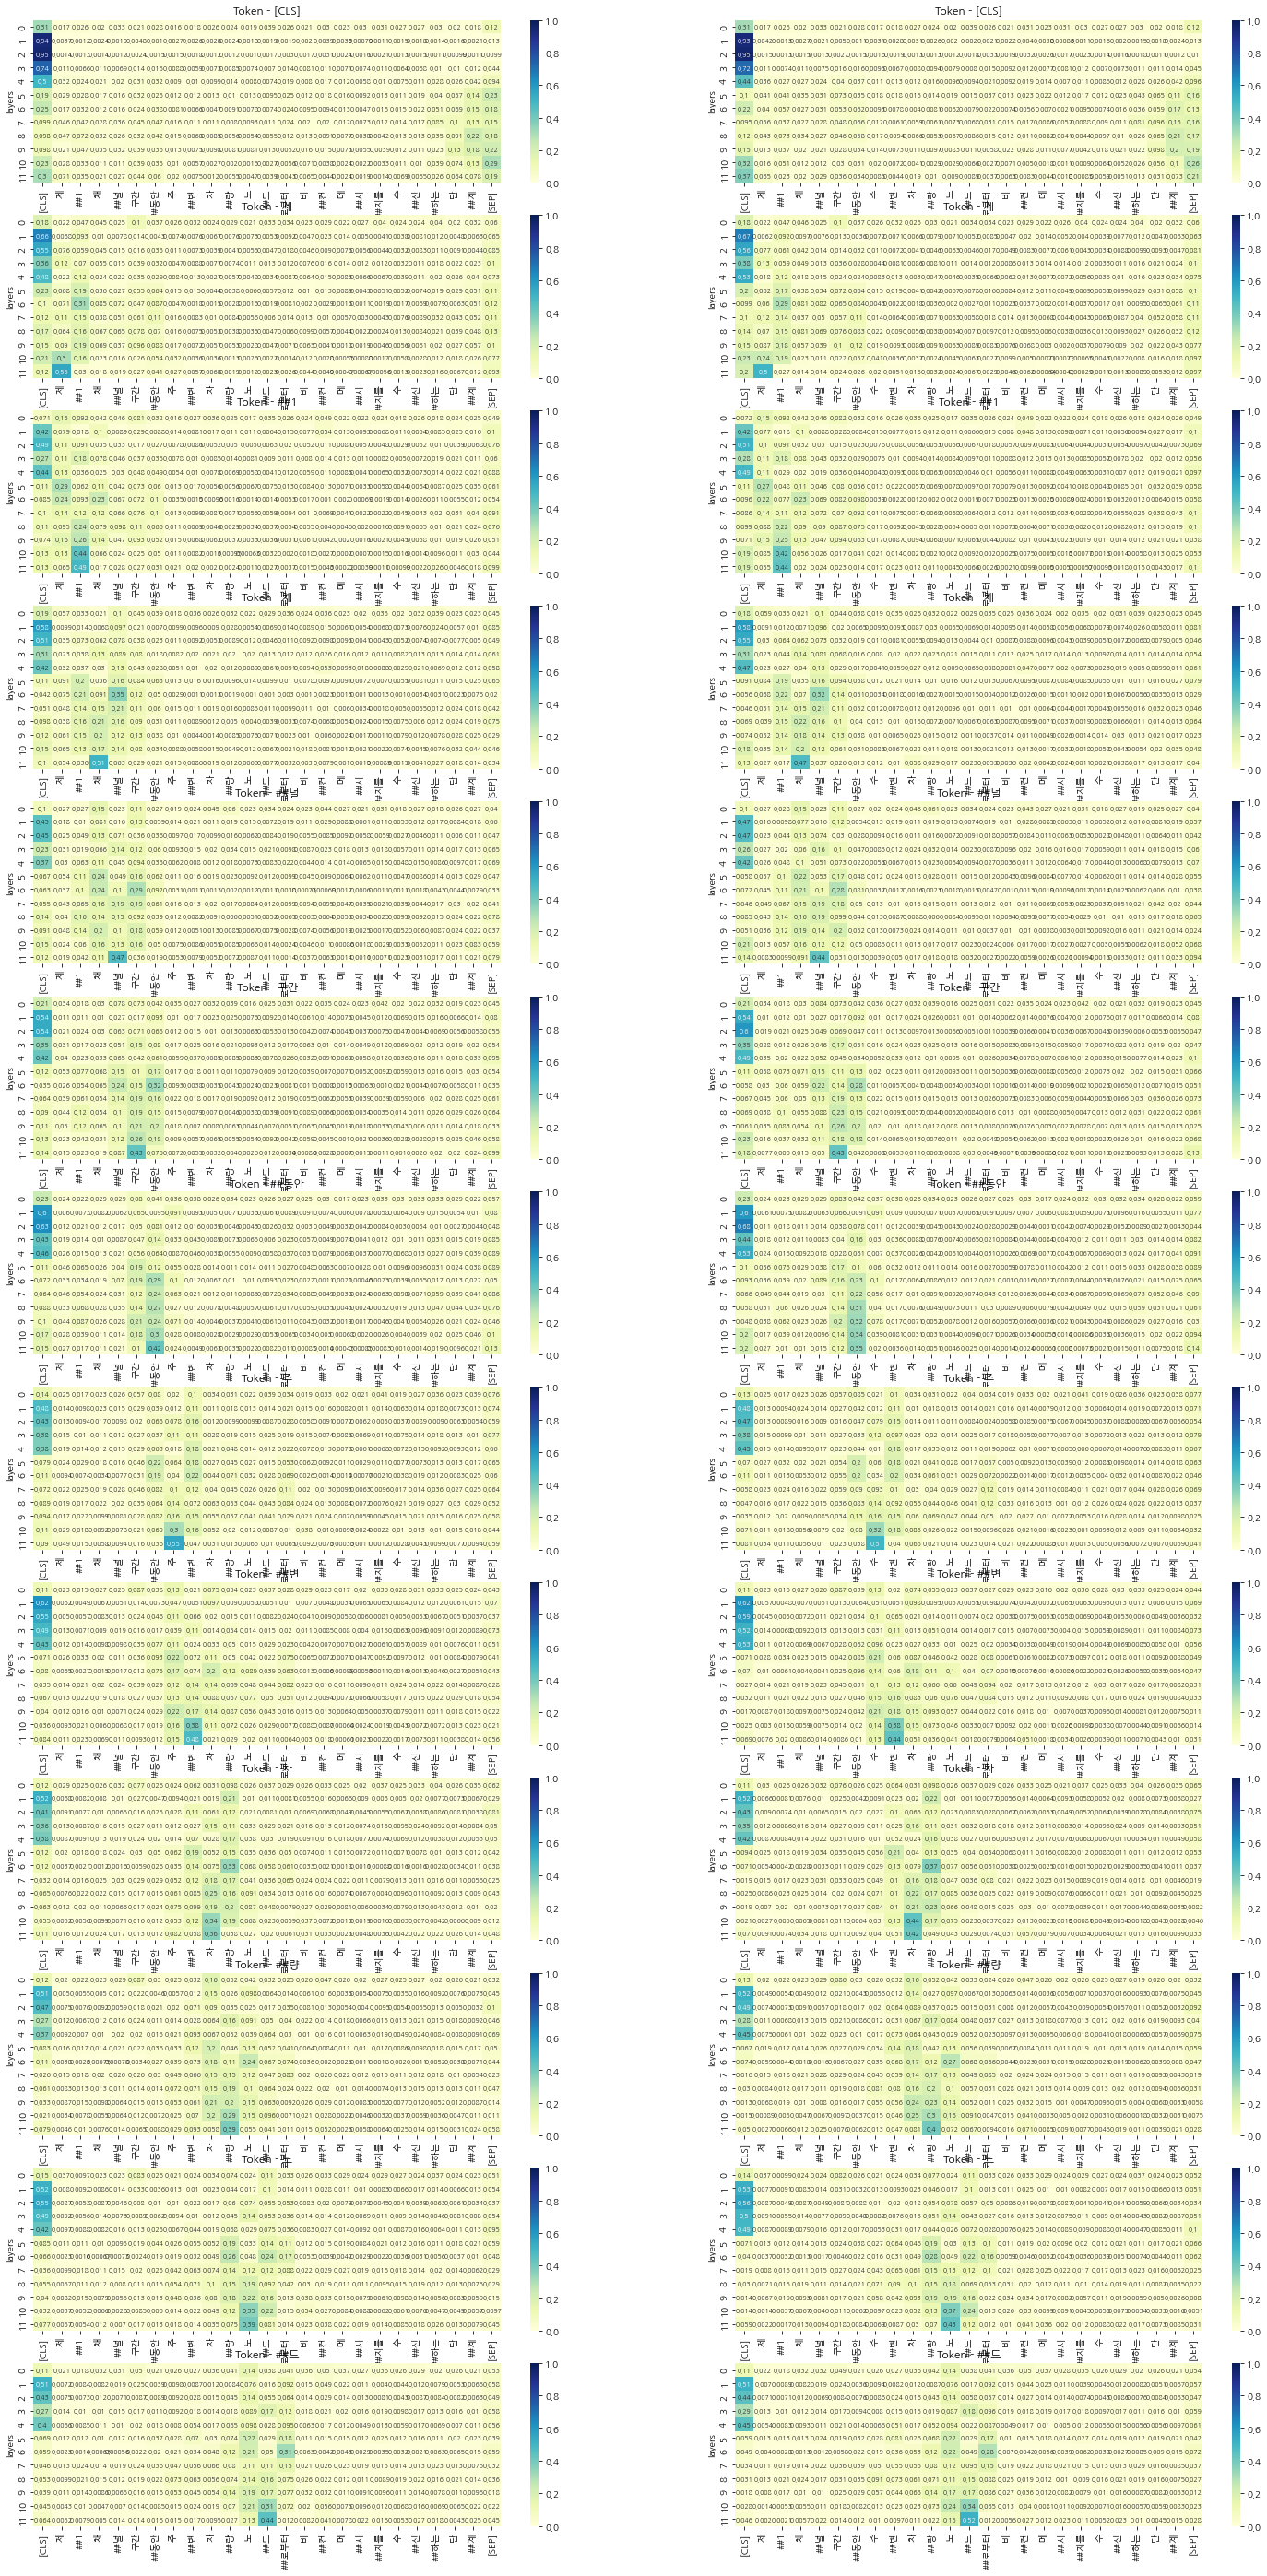

In [137]:
cols = 2
rows = len(attentions_pos)+1

fig, axes = plt.subplots(rows, cols, figsize = (25,50))
# fig, (axes1, axes2) = plt.subplots(rows, cols, figsize = (10,50))
# axes = axes.flat
for p_pos in range(finetuned_attentions.shape[0]):
    attentions_pos = attentions[p_pos]
    avg_attention = attentions_pos.mean(dim = 0)
    finetuned_attentions_pos = finetuned_attentions[p_pos]
    finetuned_avg_attention = finetuned_attentions_pos.mean(dim = 0)

    sns.heatmap(avg_attention.detach().numpy(), ax = axes[p_pos, 0], 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':7}, cmap='YlGnBu')
    sns.heatmap(finetuned_avg_attention.detach().numpy(), ax = axes[p_pos, 1], 
                vmin = 0, vmax = 1, xticklabels= tok, annot=True, annot_kws={'size':7}, cmap='YlGnBu')
    axes[p_pos,0].set_title(f'Token - {tok[p_pos]}' )
    axes[p_pos,0].set_ylabel('layers')
    axes[p_pos,1].set_title(f'Token - {tok[p_pos]}' )
    axes[p_pos,1].set_ylabel('layers')
plt.savefig(f'result_image/att_compare_untrained_tokenizer.png')

In [ ]:
# http://machinelearningkorea.com/2019/07/09/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8-transformer%EC%99%80-%EC%96%B4%ED%85%90%EC%85%98-attention%EC%9D%84-%ED%86%B5%ED%95%B4%EC%84%9C-bert%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0/
# self-attention을 구하기 위해 Query, Key, Value 세 벡터 필요.
# 예를들어 ‘사랑’이라는 단어와 ‘통계’라는 단어가 있으면 사랑이라는 단어에도 Q,K,V가 존재
# 컴퓨터에 대한 단어에도 Q,K,V가 있습니다.
# 여기서 사랑이라는 단어에 주목할때는 Q(사랑) X K(사랑) 이라는 공식으로 점수가 나오게 되며,
# 사랑이라는 단어가 통계랑도 관련이 있는지 살펴보기 위해 Q(사랑) X K(통계)라는 공식으로 점수를 매기게 됩니다.
# 당연히 Q(사랑) X K(사랑)으로 산출되는 값이 더 크겠죠.
# 그래서 이렇게 산출된 값을 소프트맥스 변환시킨 다음에, 각각의 변환값을 V와 곱해서 이를 더하면,
# 다른 것들과 연관되긴 연관되었으나, 실제 영향이 많고 관련이 많은 것들이 점수를 많이 얻게 됩니다.

# XLNET
# XLNET은 Transformer XL을 이용합니다. 
# Transformer XL은 트랜스포머의 셀링 포인트였던 시퀀스를 한꺼번에 넣고 처리하던 부분 (RNN계열은 하나씩 연속적으로 처리가 되지만) 에
# RNN과 같은 개념을 다시 적용합니다.
# 즉, 단어레벨이 아니라 문장레벨 (시퀀스레벨)로 Recurrency를 심었다는 것입니다.
# Position Embedding은 어떻게 할지 이슈가 발생할수는 있지만 단어사이의 상대적인 관계에 의해 계산이 됩니다.

# BERT의 기존 방법은 [MASK]를 뚫어 놓고 이를 맞추는 식으로 훈련했는데, 
# 한 시퀀스 안에서는 동시다발적으로 이를 맞추기 때문에 서로 연관성이 있는것도 연관성이 없게끔 훈련이 될수 있는데,
# 이러한경우에는 시퀀스마다 RNN처럼 연관성을 가지는것이 더 나을수도 있습니다.